### Homebrew Negative Binomial distribution and MLE

This is needed because the standard PMF for the negative binomial won't work. Lloyd-Smith et al used a parameterisation that uses the mean as a parameter. Before we use scipy's MLE method to fit that distribution, check that:

- we can define a new PMF that is the same parameterisation that scipy uses, or very close
- check that the MLE method will accept the new PMF
- make sure the fitted parameters are very similar under different parameter values



### Which PMF to use

Scipy in Python uses this Negative Binomial PMF:

Given shape, scale $ = n, p $

$ Z \sim NB(k| n,p) = \left( \begin{matrix} n - 1 + k \\ n - 1 \end{matrix} \right) p^n(1-p)^k $ and $ k, n \in \mathbb{N} $

Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.nbinom.html

But this notation only works for integer values of $ n $, so to use Lloyd-Smith's method, we should re-write the PMF to use the $ \Gamma $ function, which extends the domain of a factorial into the non-integer positive real numbers. Or perhaps we can avoid the gamma aswell.

The first task is to keep this parameterisation, but loosen the constraint for $ n $ to be an integer, since scipy already allows that.

We can rearrange the above distribution:

$ \left( \begin{matrix} n - 1 + k \\ n - 1 \end{matrix} \right) = \frac{(n - 1 + k)!}{k!(n-1)!}$

It would be helpful if there was no $ (n - 1)! $, so:

$ (n - 1 + k)! = (n - 1 + k)(n - 1 + (k-1))(n - 1 + (k-2))...(n - 1)! $

$ (n - 1 + k)! = \prod_{i=0}^{k-1} (n - 1 + k-i) (n - 1)! $

Now we cancel $ (n - 1)! $:

$ \frac{(n - 1 + k)!}{(n-1)! k! } = \frac{\prod_{i=0}^{k-1} (n - 1 + k-i) (n - 1)!}{k!(n-1)!} $

$ \frac{(n - 1 + k)!}{(n-1)! k! } = \frac{\prod_{i=0}^{k-1} (n - 1 + k-i)}{k!} $

$ Z \sim NB(k| n,p) = \frac{\Large \prod_{i=0}^{k-1} (n - 1 + k-i)}{\Large k!} p^n(1-p)^k $ and $ k \in \mathbb{N} $

Alternatively, we can express the PMF using the gamma function:

$ Z \sim NB(k| n,p) = \left( \frac{ \Gamma(n + k) }{ \Gamma(n)k!} \right) p^n(1-p)^k, k \in \mathbb{N} $ and $ k \in \mathbb{N} $

Both of those allow $ n $ to not be an integer

Test these against the standard nbinom.pmf()

In [2]:
# We require this to make scipy.stats.fit allow nbinom n param to be non-integer
# https://stackoverflow.com/questions/79643162/non-integral-optimizer-parameters-in-scipy-stats-fit

from scipy.optimize import differential_evolution
from scipy.stats._discrete_distns import nbinom_gen, _ShapeInfo
from scipy.stats import fit

class PatchedNBinom(nbinom_gen):
    def _shape_info(self):
        # in Shapeinfo we specify 'n' as non-integer
        return [_ShapeInfo("n", False, (0, np.inf), (True, False)),
                _ShapeInfo("p", False, (0, 1), (True, True))]

def optimizer(fun, bounds, *, integrality):
    return differential_evolution(fun, 
                                  bounds, 
                                  strategy='best2bin',
                                  integrality=[False, False, False])

nbinom = PatchedNBinom(name = 'nbinom')

In [3]:
from math import factorial, gamma, prod

# Equivalence of gamma and factorial... quick sanity check
n=5
assert(gamma(n) == factorial(n-1))
assert(gamma(n+1) == factorial(n))

### WHICH PMF IS CLOSER TO SCIPY STATS

def check_PMF_2_preferable(n, p):
    k = list(range(0,100))
    
    custom_1 = []
    for k_i in k:
        custom_i = ( (prod([n-1+k_i-i for i in range(0,k_i)]) ) / factorial(k_i) ) * p**n * (1 - p)**k_i
        custom_1.append(custom_i)
    
    custom_2 = []
    for k_i in k:
        custom_i = ( gamma(k_i + n) / (gamma(n) * factorial(k_i)) ) * p**n * (1 - p)**k_i
        custom_2.append(custom_i)
    
    y_standard = nbinom.pmf(k, n=n, p=p)
    
    error_1 = sum(abs(custom_1 - y_standard))
    error_2 = sum(abs(custom_2 - y_standard))

    #print(error_1, error_2)
    return error_1 > error_2

print("Method 2 is better:", check_PMF_2_preferable(n=5.89, p=0.5))
print("Method 2 is better:", check_PMF_2_preferable(n=2.9, p=0.3))
print("Method 2 is better:", check_PMF_2_preferable(n=3.2, p=0.7))
print("Method 2 is better:", check_PMF_2_preferable(n=9.0001, p=0.2))
print("Method 2 is better:", check_PMF_2_preferable(n=5, p=0.02))

# It seems that under different parameter values, using the first option is closer to scipy.stats

Method 2 is better: False
Method 2 is better: False
Method 2 is better: False
Method 2 is better: False
Method 2 is better: False


In [4]:
import numpy as np
import pandas as pd
from math import factorial, gamma, prod
import matplotlib.pyplot as plt
from scipy.stats import fit, rv_discrete
from scipy.stats._distn_infrastructure import _ShapeInfo

class NbinomCustom(rv_discrete):

    def _pmf(self, k, n, p):
        pmf_values = []

        if isinstance(n, np.ndarray):
            n = n[0] # an array all the same for n, p
        if isinstance(p, np.ndarray):
            p = p[0]

        # the standard method seems to use a np array, but I couldn't get it to work. So, verbosely use each element
        for k_i in k:
            if not isinstance(p, int):
                k_i = int(k_i)
            #pmf_i = ( gamma(k_i + n) / (gamma(n) * gamma(k_i+1)) ) * p**n * (1 - p)**k_i
            pmf_i = ( (prod([n-1+k_i-i for i in range(0,k_i)]) ) / factorial(k_i) ) * p**n * (1 - p)**k_i
            pmf_values.append(pmf_i)
        return pmf_values
    
    def _argcheck(self, n, p):
        n_check = 0 < n
        p_check = 0 < p <= 1
        return n_check & p_check

    def _param_info(self):
        # required to work with MLE in scipy.stats.fit
        return [_ShapeInfo("n", False, (0, np.inf), (True, False)),
                _ShapeInfo("p", False, (0, 1), (True, True)),
                _ShapeInfo("loc", False, (0, 100), (True, True))]
    
nbinom_custom = NbinomCustom(name='NbinomCustom')

def method_of_moments(data):
    # SCIPY defines these moments for the NB distribution https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.nbinom.html
    mu = np.mean(data)
    sigma_squared =np.var(data)
    n = mu**2/(sigma_squared - mu)
    p = mu/sigma_squared
    return n, p
    
#fitted_distribution_custom.plot()
#plt.title("n~{0:.5f},p~{1:.5f}".format(fitted_distribution_custom.params.n, fitted_distribution_custom.params.p))
#plt.show()
    
#fitted_distribution_standard.plot()
#plt.title("n~{0:.5f},p~{1:.5f}".format(fitted_distribution_standard.params.n, fitted_distribution_standard.params.p))
#plt.show()


In [23]:
def compare_MOM_MLE_custom_standard(n,p,exp_count):
    results = pd.DataFrame(columns=["MOM_n_error", "MOM_p_error", 
                                    "custom_dist_n_error", "custom_dist_p_error", 
                                    "standard_dist_n_error", "standard_dist_p_error"])
    
    for experiment in range(0,exp_count):
        data = nbinom.rvs(n=n, p=p, size = 4000)

        MOM_n, MOM_p = method_of_moments(data)
        fitted_distribution_custom = fit(nbinom_custom, data, ((MOM_n-(MOM_n*0.5), MOM_n+(MOM_n*0.5)),(0,1)))
        fitted_distribution_standard = fit(nbinom, data, ((MOM_n-(MOM_n*0.5), MOM_n+(MOM_n*0.5)),(0,1)))
    
        MOM_n_error = abs(n - MOM_n)
        MOM_p_error = abs(p - MOM_p)
        custom_dist_n_error = abs(n - fitted_distribution_custom.params.n)
        custom_dist_p_error = abs(p - fitted_distribution_custom.params.p)
        standard_dist_n_error = abs(n - fitted_distribution_standard.params.n)
        standard_dist_p_error = abs(p - fitted_distribution_standard.params.p)

        results.loc[len(results)] = [MOM_n_error, MOM_p_error, 
                                     custom_dist_n_error, custom_dist_p_error, 
                                     standard_dist_n_error, standard_dist_p_error]
        
    return results

experiment_summaries = pd.DataFrame(columns=["shape_parameters", 
                                             "MOM_n_error_sum", "MOM_p_error_sum",
                                             "custom_dist_n_error_sum", "custom_dist_p_error_sum",
                                             "standard_dist_n_error_sum", "standard_dist_p_error_sum"])

for n, p in [(5.89,0.5),
            (2.9, 0.3),
            (1.01, 0.9),
            (8.99, 0.21)]:
    print(n,p)
    exp_count = 20
    x = list(range(0,exp_count))
    results = compare_MOM_MLE_custom_standard(n=n, p=p, exp_count=exp_count)
    shape_params = "n~{0:.2f},p~{1:.2f}".format(n, p)
    experiment_summaries.loc[len(experiment_summaries)] = [shape_params,
                                                           sum(results["MOM_n_error"]),
                                                           sum(results["MOM_p_error"]),
                                                           sum(results["custom_dist_n_error"]),
                                                           sum(results["custom_dist_p_error"]),
                                                           sum(results["standard_dist_n_error"]),
                                                           sum(results["standard_dist_p_error"])]

5.89 0.5
2.9 0.3
1.01 0.9
8.99 0.21


In [24]:
experiment_summaries

,shape_parameters,MOM_n_error_sum,MOM_p_error_sum,custom_dist_n_error_sum,custom_dist_p_error_sum,standard_dist_n_error_sum,standard_dist_p_error_sum
0,"n~5.89,p~0.50",5.220447,0.222534,4.966121,0.208069,5.004217,0.221908
1,"n~2.90,p~0.30",2.016827,0.138515,1.923890,0.127810,1.721591,0.112508
2,"n~1.01,p~0.90",7.553014,0.429209,7.681198,0.464901,7.318932,0.415622
3,"n~8.99,p~0.21",3.410661,0.066213,4.770082,0.099623,5.431401,0.103715


There is probably a statistical test for this. But, without a test, this appears to indicate that the MOM sometimes performs as well as the MLE methods. MLE using scipy's standard implementation of the Negative Binomial distribution is sometimes better than the custom Negative Binomial distribution defined above.

This indicates that we have successfully defined a new PMF and used Scipy's MLE to fit parameters. Now we can do this again for the parameterisation that takes the sample mean as a parameter.

The below parameterisation was cited by Lloyd-Smith et al: Mathematical Statistics and Data Analysis 3ed, P. 319

$ Z \sim NB(x | m, k) = \left(1+\frac{m}{k}\right)^{-k} \cdot \frac{\Gamma(k+x)}{x!\Gamma(k)} \cdot \left(\frac{m}{m+k}\right)^x, x \in \mathbb{N} $

In [5]:
class NbinomReparameterised(rv_discrete):

    def _pmf(self, x, m, k):
        pmf_values = []

        if isinstance(m, np.ndarray):
            m = m[0] # an array all the same for n, p
        if isinstance(k, np.ndarray):
            k = k[0]

        # the standard method seems to use a np array, but I couldn't get it to work. So, verbosely use each element
        for x_i in x:
            if not isinstance(x, int):
                x_i = int(x_i)
            pmf_i = (1+m/k)**(-k) * (gamma(k+x_i)/(factorial(x_i)*gamma(k))) * (m/(m+k))**x_i
            pmf_values.append(pmf_i)
        return pmf_values
    
    def _argcheck(self, m, k):
        m_check = 0 < m
        k_check = 0 < k
        # there's no reason to assume that k would be less than one in this parameterisation
        return m_check & k_check

    def _param_info(self):
        # required to work with MLE in scipy.stats.fit
        return [_ShapeInfo("m", False, (0, np.inf), (True, False)),
                _ShapeInfo("k", False, (0, np.inf), (True, False)),
                _ShapeInfo("loc", False, (0, np.inf), (True, True))]
    
nbinom_reparameterised = NbinomReparameterised(name='NbinomReparameterised')

class NbinomReparameterisedReciprocal(rv_discrete):

    def _pmf(self, x, m, k):
        pmf_values = []

        if isinstance(m, np.ndarray):
            m = m[0] # an array all the same for n, p
        if isinstance(k, np.ndarray):
            k = k[0]

        # The article by Lloyd-Smith et al says it's more reliable to fit the reciprocal of k, alpha=1/k, and then convert it back later
        # But the issues with homogeneous data only happens with k>1
        
        alpha = 1/k
            
        # the standard method seems to use a np array, but I couldn't get it to work. So, verbosely use each element
        for x_i in x:
            if not isinstance(x, int):
                x_i = int(x_i)
            pmf_i = (1+m/alpha)**(-alpha) * (gamma(alpha+x_i)/(factorial(x_i)*gamma(alpha))) * (m/(m+alpha))**x_i
            pmf_values.append(pmf_i)
        return pmf_values
    
    def _argcheck(self, m, k):
        m_check = 0 < m
        k_check = 0 < k
        # there's no reason to assume that k would be less than one in this parameterisation
        return m_check & k_check

    def _param_info(self):
        # required to work with MLE in scipy.stats.fit
        return [_ShapeInfo("m", False, (0, np.inf), (True, False)),
                _ShapeInfo("k", False, (0, np.inf), (True, False)),
                _ShapeInfo("loc", False, (0, np.inf), (True, True))]
    
nbinom_reparam_reciprocal = NbinomReparameterisedReciprocal(name='NbinomReparameterisedReciprocal')

def method_of_moments(data):
    mu = np.mean(data)
    sigma_squared = np.var(data)
    m = mu
    k = mu**2/(sigma_squared - mu)
    return m, k


In [129]:
def compare_MOM_MLE_reparameterised(m,k,exp_count):
    results = pd.DataFrame(columns=["MOM_m_error", "MOM_k_error", 
                                    "reparam_dist_m_error", "reparam_dist_k_error",
                                    "reparam_reciprocal_dist_m_error", "reparam_reciprocal_dist_k_error"])
    
    for experiment in range(0,exp_count):
        data = nbinom_reparameterised.rvs(m=m, k=k, size = 400)
        
        MOM_m, MOM_k = method_of_moments(data)
        fitted_distribution_reparam = fit(nbinom_reparameterised, data, ((MOM_m, MOM_m),(0.01, 100))) # set m to be the sample mean, as Lloyd-Smith did
        fitted_distribution_reparam_reciprocal = fit(nbinom_reparam_reciprocal, data, ((MOM_m, MOM_m), (0.01, 100)))
        
        MOM_m_error = abs(m - MOM_m)
        MOM_k_error = abs(k - MOM_k)
        reparam_dist_m_error = abs(m - fitted_distribution_reparam.params.m)
        reparam_dist_k_error = abs(k - fitted_distribution_reparam.params.k)
        reparam_reciprocal_dist_m_error = abs(m - fitted_distribution_reparam_reciprocal.params.m)
        reparam_reciprocal_dist_k_error = abs(k - 1/fitted_distribution_reparam_reciprocal.params.k) # then convert alpha back to k

        results.loc[len(results)] = [MOM_m_error, MOM_k_error, 
                                     reparam_dist_m_error, reparam_dist_k_error,
                                     reparam_reciprocal_dist_m_error, reparam_reciprocal_dist_k_error]
        
    return results

# You won't need to compare m in this case, since m is the sample mean, so the method of moments will give precisely the same value as the fitted dist.
experiment_summaries = pd.DataFrame(columns=["shape_parameters",
                                             "MOM_k_error_sum",
                                             "reparam_dist_k_error_sum",
                                             "reparam_reciprocal_dist_k_error"])

for m, k in [(0.4, 9),
            (1.1,0.5),
            (2.2, 2),
            (0.99, 3),
            (1.2, 0.21)]:
    print(m,k)
    exp_count = 200
    x = list(range(0,exp_count))
    results = compare_MOM_MLE_reparameterised(m=m, k=k, exp_count=exp_count)
    shape_params = "m~{0:.2f},k~{1:.2f}".format(m, k)
    experiment_summaries.loc[len(experiment_summaries)] = [shape_params,
                                                           #sum(results["MOM_m_error"]),
                                                           sum(results["MOM_k_error"]),
                                                           #sum(results["reparam_dist_m_error"]),
                                                           sum(results["reparam_dist_k_error"]),
                                                           #sum(results["reparam_reciprocal_dist_m_error"]),
                                                           sum(results["reparam_reciprocal_dist_k_error"]),]

0.4 9
1.1 0.5
2.2 2
0.99 3
1.2 0.21


In [131]:
experiment_summaries

,shape_parameters,MOM_k_error_sum,reparam_dist_k_error_sum,reparam_reciprocal_dist_k_error
0,"m~0.40,k~9.00",4453.610249,7215.886458,7334.154513
1,"m~1.10,k~0.50",14.649186,11.386014,11.385991
2,"m~2.20,k~2.00",54.294532,46.295274,46.397312
3,"m~0.99,k~3.00",207.576514,197.193268,197.196461
4,"m~1.20,k~0.21",6.874068,4.538416,4.538403


So, the claim by Lloyd-Smith et al that the MOM is generally worse than MLE is true for this parameterisation. Using the recipricol of k doesn't seem to make muck difference under different parameter settings. But, they showed that using $ \alpha $ leads to a more symmetric distribution for the purpose of sampling (bootstrapping). So, we may wish to use the reciprocal distribution 

FitParams(m=np.float64(0.8), k=np.float64(0.19536691055710376), loc=np.float64(0.0))
The data mean is: 0.7946


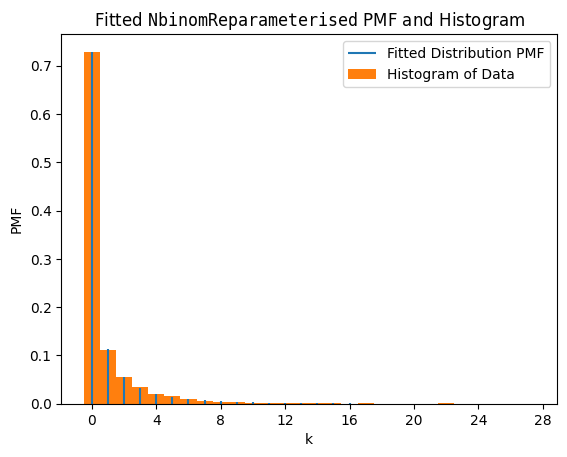

In [8]:
# Example using the PMF that uses sample mean as param

m=0.8
k=0.2
data = nbinom_reparameterised.rvs(m=m, k=k, size = 10000)
fitted_distribution_reparam = fit(nbinom_reparameterised, data, ((m, m),(0.01, 100))) # set m to be the sample mean, as Lloyd-Smith did
fitted_distribution_reparam.plot()
print(fitted_distribution_reparam.params)
print("The data mean is:", np.mean(data))

In [ ]:
### Log Likelihood for reparameterised function



In [27]:
from math import factorial, gamma
import numpy as np

x = 2 #[0,1,2,3,4]
m = 2
k = 0.5
def f(x, m, k):
    if isinstance(x, int):
        x = [x]
    pmf_values = []
    for x_i in x:
        pmf_value = (1 + m/k)**(-k) * (gamma(k+x_i) / (factorial(x_i)*gamma(k)) ) * (m/(m+k))**x_i
        pmf_values.append(pmf_value)
    return pmf_values

sum_log_1 = np.log(f(x,m,k)) #np.sum(np.log(f(x,m,k)))
sum_log_1

array([-2.23183531])

In [28]:
# By using log laws I derived this expression

#n = len(x)

n=1

sum_log_2 = -k*n*np.log(1 + m/k) + np.sum(np.log(gamma(k + x))) - np.sum(np.log(factorial(x))) - n*np.log(gamma(k)) + (np.log(m) - np.log(m+k)) * np.sum(x) 
sum_log_2

np.float64(-2.2318353118571954)